In [57]:
import pandas as pd
import numpy as np
import spacy
import nltk

import nltk
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import string
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')

from string import punctuation
stop_words = set( stopwords.words('english'))

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer

spacy.load('en_core_web_lg')

import os
from os import walk
from tqdm import tqdm
from tqdm.notebook import tqdm as tqdm_notebook
import numpy as np
import seaborn as sns

tqdm_notebook.pandas()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rchaks/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/rchaks/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/rchaks/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/rchaks/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# Identify Fallen Angels

In [58]:
df = pd.read_csv('consumer_staples.csv')#.drop('Unnamed: 0', axis = 1)
df['datadate'] = pd.to_datetime(df['datadate'])
df['year'] = df['datadate'].dt.year

df = df.set_index('datadate')
df = df.dropna(subset = ['splticrm'])

df['next_splticrm'] = df.groupby(['tic','gvkey'])['splticrm'].shift(-1)
# df = df.dropna(subset = ['next_splticrm'])

df.dropna(inplace=True)
df

,gvkey,splticrm,gsector,conm,tic,year,next_splticrm
datadate,,,,,,,
2000-01-31,1239,BBB+,30,ALBERTO-CULVER CO,ACV.1,2000,BBB+
2000-02-29,1239,BBB+,30,ALBERTO-CULVER CO,ACV.1,2000,BBB+
2000-03-31,1239,BBB+,30,ALBERTO-CULVER CO,ACV.1,2000,BBB+
2000-04-30,1239,BBB+,30,ALBERTO-CULVER CO,ACV.1,2000,BBB+
2000-05-31,1239,BBB+,30,ALBERTO-CULVER CO,ACV.1,2000,BBB+
...,...,...,...,...,...,...,...
2014-05-31,272705,B,30,ATRIUM INNOVATIONS INC,ATBIF,2014,B
2014-06-30,272705,B,30,ATRIUM INNOVATIONS INC,ATBIF,2014,B
2014-07-31,272705,B,30,ATRIUM INNOVATIONS INC,ATBIF,2014,B


In [61]:
print(df.columns.values)

['gvkey' 'splticrm' 'gsector' 'conm' 'tic' 'year' 'next_splticrm']


In [17]:
# User: rkarthick1997
# Pass: ABInBevCapstone5

In [18]:
df.splticrm.value_counts().index

Index(['BBB', 'B+', 'A', 'BBB-', 'BBB+', 'A+', 'B', 'BB-', 'BB', 'A-', 'BB+',
       'AA-', 'B-', 'AA', 'D', 'CCC+', 'AAA', 'CCC-', 'CC', 'AA+', 'CCC',
       'SD'],
      dtype='object')

In [19]:
def is_invest_grade(rating: str)->bool:
    return rating.startswith('A') or rating in {'BBB','BBB+'}

def junk_drop(rating:str, next_rating:str):
    grade = 'invest'
    out = []
    for item in zip(rating, next_rating):
        if is_invest_grade(item[0]) == True:
            if is_invest_grade(item[1]) == False:
                grade = 'fallen'
        else:
            grade = 'junk'
        out.append(grade)
    return out


df['grade'] = junk_drop(df['splticrm'],df['next_splticrm'])
df

,gvkey,splticrm,gsector,conm,tic,year,next_splticrm,grade
datadate,,,,,,,,
2000-01-31,1239,BBB+,30,ALBERTO-CULVER CO,ACV.1,2000,BBB+,invest
2000-02-29,1239,BBB+,30,ALBERTO-CULVER CO,ACV.1,2000,BBB+,invest
2000-03-31,1239,BBB+,30,ALBERTO-CULVER CO,ACV.1,2000,BBB+,invest
2000-04-30,1239,BBB+,30,ALBERTO-CULVER CO,ACV.1,2000,BBB+,invest
2000-05-31,1239,BBB+,30,ALBERTO-CULVER CO,ACV.1,2000,BBB+,invest
...,...,...,...,...,...,...,...,...
2014-05-31,272705,B,30,ATRIUM INNOVATIONS INC,ATBIF,2014,B,junk
2014-06-30,272705,B,30,ATRIUM INNOVATIONS INC,ATBIF,2014,B,junk
2014-07-31,272705,B,30,ATRIUM INNOVATIONS INC,ATBIF,2014,B,junk


In [20]:
def compare(x):
    return x[x.grade.apply(lambda i: i != 'junk')].drop('year', axis = 1)
    # if any(x.grade == 'fallen'):
    #     return x[x.grade.apply(lambda i: i in {'invest','fallen'})].drop('year', axis = 1)
    # else:
    #     return x[x.grade.apply(lambda i: i  == 'invest')].drop('year', axis = 1)
    # print(type(x), x.columns)

In [21]:
df = df.groupby('year').apply(compare).reset_index()#.set_index('datadate')
df

,year,datadate,gvkey,splticrm,gsector,conm,tic,next_splticrm,grade
0,2000,2000-01-31,1239,BBB+,30,ALBERTO-CULVER CO,ACV.1,BBB+,invest
1,2000,2000-02-29,1239,BBB+,30,ALBERTO-CULVER CO,ACV.1,BBB+,invest
2,2000,2000-03-31,1239,BBB+,30,ALBERTO-CULVER CO,ACV.1,BBB+,invest
3,2000,2000-04-30,1239,BBB+,30,ALBERTO-CULVER CO,ACV.1,BBB+,invest
4,2000,2000-05-31,1239,BBB+,30,ALBERTO-CULVER CO,ACV.1,BBB+,invest
...,...,...,...,...,...,...,...,...,...
160,2012,2012-04-30,1920,BBB,30,AVON PRODUCTS,AVP,BBB-,fallen
161,2012,2012-11-30,3362,BBB,30,CONAGRA BRANDS INC,CAG,BBB-,fallen
162,2013,2013-05-31,5568,BBB+,30,KRAFT HEINZ CO,KHC,BB-,fallen
163,2014,2014-12-31,9359,BBB,30,SAFEWAY INC,SWY,B,fallen


datadate  gvkey splticrm                      conm    tic  \
year gsector                                                               
2000 30      2000-01-31   1239     BBB+         ALBERTO-CULVER CO  ACV.1   
     30      2000-02-29   1239     BBB+         ALBERTO-CULVER CO  ACV.1   
     30      2000-03-31   1239     BBB+         ALBERTO-CULVER CO  ACV.1   
     30      2000-04-30   1239     BBB+         ALBERTO-CULVER CO  ACV.1   
     30      2000-05-31   1239     BBB+         ALBERTO-CULVER CO  ACV.1   
...                 ...    ...      ...                       ...    ...   
2012 30      2012-04-30   1920      BBB             AVON PRODUCTS    AVP   
     30      2012-11-30   3362      BBB        CONAGRA BRANDS INC    CAG   
2013 30      2013-05-31   5568     BBB+            KRAFT HEINZ CO    KHC   
2014 30      2014-12-31   9359      BBB               SAFEWAY INC    SWY   
2015 30      2015-10-31   3505     BBB+  MOLSON COORS BEVERAGE CO    TAP   

             next_splticrm   grade  
year gsector                        
2000 30               BBB+  invest  
     30               BBB+  invest  
     30               BBB+  invest  
     30               BBB+  invest  
     30               BBB+  invest  
...                    ...     ...  
2012 30               BBB-  fallen  
     30               BBB-  fallen  
2013 30                BB-  fallen  
2014 30                  B  fallen  
2015 30               BBB-  fallen  

[165 rows x 7 columns]

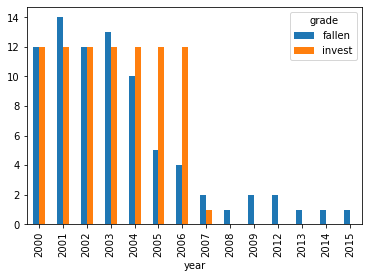

In [23]:
# df[df.grade == 'fallen'].year.value_counts()
df.groupby(['year','grade']).size().unstack().plot(kind = 'bar')
df.set_index(['year','gsector'])

In [24]:
# def is_invest_grade(rating: str)->bool:
#     return rating.startswith('A') or rating in {'BBB','BBB+'}

# def junk_drop(rating:str, next_rating:str):
#     return rating.apply(lambda x: is_invest_grade(x) == True) & next_rating.apply(lambda x: is_invest_grade(x) == False)


# df = df[junk_drop(df['splticrm'],df['next_splticrm'])].reset_index()
# df

In [25]:
## All rating drops counted. Need only Investment grade -> Junk

# rating_list = ['A-','BBB+','BBB-', 'BBB','BB+','BB','BB-', 'B+', 'B','B-',  'CCC+',  'CCC', 'CCC-', 'CC','D']
# df['rating_drop'] = 0

# for i in df.index:
#     if rating_list.index(df.loc[i,'Next Filing Rating']) > rating_list.index(df.loc[i,'splticrm']):
#         df.loc[i,'rating_drop'] = 1
# df.head()
# df[df['rating_drop'] == 1]

In [29]:
subset_cols = ['gvkey',
'datadate',
'fyear',
'indfmt',
'consol',
'popsrc',
'datafmt',
'tic',
'curcd',
'at',
'gp',
'invt',
'nits',
'oiadp',
'revt',
'txt',
'cik',
'costat',
'mkvalt']#,
# 'ggroup']

In [30]:
annual_data = pd.read_csv('annual_data.csv', low_memory= False, usecols = subset_cols)
# fill na ciks
annual_data['datadate'] = pd.to_datetime(annual_data['datadate'])
annual_data['fyear'] = annual_data['datadate'].dt.year
print(annual_data.shape)
annual_data.head()

(6973, 19)


,gvkey,datadate,fyear,indfmt,consol,popsrc,datafmt,tic,curcd,at,gp,invt,nits,oiadp,revt,txt,cik,costat,mkvalt
0,1239,2000-09-30,2000,INDL,C,D,STD,ACV.1,USD,1389.819,1177.988,445.257,NaN,164.233,2247.163,51.097,1368457.0,I,1525.5599
1,1239,2001-09-30,2001,INDL,C,D,STD,ACV.1,USD,1516.501,1314.066,478.311,NaN,189.066,2494.180,56.860,1368457.0,I,2068.9633
2,1239,2002-09-30,2002,INDL,C,D,STD,ACV.1,USD,1729.491,1337.861,522.208,NaN,234.428,2650.976,74.127,1368457.0,I,2776.7847
3,1239,2003-09-30,2003,INDL,C,D,STD,ACV.1,USD,1945.609,1487.958,531.157,NaN,273.791,2891.417,89.247,1368457.0,I,3430.7324
4,1239,2004-09-30,2004,INDL,C,D,STD,ACV.1,USD,2058.780,1695.057,626.834,NaN,236.512,3257.996,70.874,1368457.0,I,3946.4187


In [32]:
annual_data.isna().sum()['cik']

206

In [33]:
merged_data = pd.merge(df,annual_data.drop(['datadate','tic'],axis= 1), how = 'left', left_on = ['gvkey','year'], right_on = ['gvkey','fyear'])
merged_data.shape

(166, 25)

In [34]:
merged_data.describe()

,year,gvkey,gsector,fyear,at,gp,invt,nits,oiadp,revt,txt,cik,mkvalt
count,166.000000,166.000000,166.0,153.000000,153.000000,152.000000,153.000000,0.0,152.000000,152.000000,152.000000,1.530000e+02,101.000000
mean,2003.277108,39770.331325,30.0,2003.124183,3236.066157,1647.306664,644.080889,NaN,310.325697,4395.179829,78.664737,1.146641e+06,3976.389056
std,2.846852,48330.462236,0.0,2.805822,4842.563151,2132.388140,616.880985,NaN,260.751578,8721.692597,51.375378,3.565107e+05,3081.023290
min,2000.000000,1239.000000,30.0,2000.000000,1024.116000,190.190000,129.977000,NaN,-7.000000,1222.046000,-102.000000,3.333000e+03,946.754000
25%,2001.000000,1239.000000,30.0,2001.000000,1589.638000,811.960000,362.738000,NaN,196.420000,1640.911750,56.860000,1.011218e+06,2068.963300
50%,2003.000000,1239.000000,30.0,2003.000000,1945.609000,1314.066000,478.311000,NaN,236.512000,2650.976000,74.127000,1.368457e+06,3430.732400
75%,2005.000000,100956.000000,30.0,2005.000000,2302.123000,1695.057000,689.692000,NaN,306.323000,3516.306750,89.247000,1.368457e+06,4116.597300
max,2015.000000,144435.000000,30.0,2015.000000,38972.348000,15913.791000,4356.000000,NaN,1897.000000,70628.860000,390.000000,1.637459e+06,23266.011300


In [35]:
merged_data.head()

,year,datadate,gvkey,splticrm,gsector,conm,tic,next_splticrm,grade,fyear,...,at,gp,invt,nits,oiadp,revt,txt,cik,costat,mkvalt
0,2000,2000-01-31,1239,BBB+,30,ALBERTO-CULVER CO,ACV.1,BBB+,invest,2000.0,...,1389.819,1177.988,445.257,NaN,164.233,2247.163,51.097,1368457.0,I,1525.5599
1,2000,2000-02-29,1239,BBB+,30,ALBERTO-CULVER CO,ACV.1,BBB+,invest,2000.0,...,1389.819,1177.988,445.257,NaN,164.233,2247.163,51.097,1368457.0,I,1525.5599
2,2000,2000-03-31,1239,BBB+,30,ALBERTO-CULVER CO,ACV.1,BBB+,invest,2000.0,...,1389.819,1177.988,445.257,NaN,164.233,2247.163,51.097,1368457.0,I,1525.5599
3,2000,2000-04-30,1239,BBB+,30,ALBERTO-CULVER CO,ACV.1,BBB+,invest,2000.0,...,1389.819,1177.988,445.257,NaN,164.233,2247.163,51.097,1368457.0,I,1525.5599
4,2000,2000-05-31,1239,BBB+,30,ALBERTO-CULVER CO,ACV.1,BBB+,invest,2000.0,...,1389.819,1177.988,445.257,NaN,164.233,2247.163,51.097,1368457.0,I,1525.5599


In [37]:
# original

fallen_angels = merged_data[['gvkey','gsector','tic','cik','datadate','grade']].drop_duplicates()
# fallen_angels.cik = fallen_angels.cik.astype(int)
fallen_angels.to_csv('fallen_angels.csv', index= False)
fallen_angels

,gvkey,gsector,tic,cik,datadate,grade
0,1239,30,ACV.1,1368457.0,2000-01-31,invest
1,1239,30,ACV.1,1368457.0,2000-02-29,invest
2,1239,30,ACV.1,1368457.0,2000-03-31,invest
3,1239,30,ACV.1,1368457.0,2000-04-30,invest
4,1239,30,ACV.1,1368457.0,2000-05-31,invest
...,...,...,...,...,...,...
160,1920,30,AVP,8868.0,2012-04-30,fallen
161,3362,30,CAG,23217.0,2012-11-30,fallen
162,5568,30,KHC,1637459.0,2013-05-31,fallen
164,9359,30,SWY,NaN,2014-12-31,fallen


grade,fallen,invest
gsector,,
30,80,85


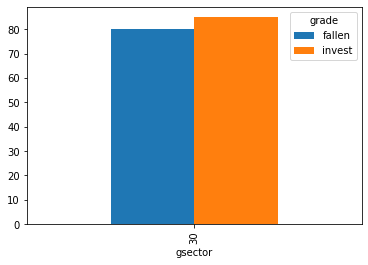

In [41]:
# fallen_angels.grade.value_counts()
fallen_angels.groupby(['gsector','grade']).size().unstack().plot(kind = 'bar')
fallen_angels.groupby(['gsector','grade']).size().unstack()

# Scrape Edgar

In [42]:
import os
from ut_msba_edgar_scraper import Downloader
from datetime import datetime
import itertools
from tqdm import tqdm

In [45]:
fallen_angels = pd.read_csv('fallen_angels.csv')
fallen_angels.datadate = pd.to_datetime(fallen_angels.datadate)
fallen_angels = fallen_angels[fallen_angels.datadate.dt.year >= 2000]
fallen_angels

,gvkey,gsector,tic,cik,datadate,grade
0,1239,30,ACV.1,1368457.0,2000-01-31,invest
1,1239,30,ACV.1,1368457.0,2000-02-29,invest
2,1239,30,ACV.1,1368457.0,2000-03-31,invest
3,1239,30,ACV.1,1368457.0,2000-04-30,invest
4,1239,30,ACV.1,1368457.0,2000-05-31,invest
...,...,...,...,...,...,...
160,1920,30,AVP,8868.0,2012-04-30,fallen
161,3362,30,CAG,23217.0,2012-11-30,fallen
162,5568,30,KHC,1637459.0,2013-05-31,fallen
163,9359,30,SWY,NaN,2014-12-31,fallen


In [119]:
def fetch_reports(args):
    downloader = Downloader()
    report_type, date, gvkey, grade = args
    date = datetime(year = 2002, month=12, day= 31) if date.year <2000 else date
    if date.month == 2:
        after_date = date.replace(year = date.year -2, month= date.month-1) if date.year >=2002 else datetime(year = 2000, month=1, day= 1)
    else:
        after_date = date.replace(year = date.year -2) if date.year >=2002 else datetime(year = 2000, month=1, day= 1)
    
    # print(f"{report_type}, {date.strftime('%Y-%m-%d')}, {after_date.strftime('%Y-%m-%d')}, {gvkey}")
    
    try:
        filings_list = downloader.get_filings(report_type,
                                            gvkey, 
                                            before= date.strftime('%Y-%m-%d'),
                                            after = after_date.strftime('%Y-%m-%d'))
        
        #option -1
        for filing in filings_list[::-1]:
            os.makedirs(f'data/raw/{grade}/', exist_ok=True)
            with open(f'data/raw/{grade}/{repr(filing)}.html','wb') as f:
                f.write(filing.get_report())
                
        # option -2
        # flag = True if grade == 'fallen' else False
        # for filing in filings_list[::-1]:
        #     if flag == True:
        #         os.makedirs(f'data/raw/fallen/', exist_ok=True)
        #         with open(f'data/raw/fallen/{repr(filing)}.html','wb') as f:
        #             f.write(filing.get_report())    
        #         flag = False
        #         continue
            
        #     os.makedirs(f'data/raw/invest/', exist_ok=True)
        #     with open(f'data/raw/invest/{repr(filing)}.html','wb') as f:
        #         f.write(filing.get_report())
    except Exception as e:
        print('Failed {gvkey},{report_type}',str(e))
    

In [120]:
os.makedirs('fallen_angels/raw', exist_ok = True)
for rows, report_type in (pbar:=tqdm(itertools.product(fallen_angels.values.tolist(), ['10-K','10-Q']))):
    gvkey, ticker, cik, date, grade = rows
    pbar.set_description(f"{report_type}, {date.strftime('%Y-%m-%d')}, {gvkey}, {grade}")
    
    if date.year >= 2000:
        fetch_reports((report_type, date, gvkey, grade))

10-Q, 2015-10-31, 3505, fallen: : 330it [06:06,  1.11s/it]  


In [121]:
!pwd

/Users/rchaks/.zshenv:1: bad assignment
/Users/rchaks/Code/GitHub/fin-modelling/consumer-staples


In [123]:
def find_files(directory: str, extension: str = '.html'):
    file_list = []
    for path, dirnames, filenames in os.walk(directory):
        for file in filenames:
            if (os.path.isfile(f'{path}/{file}') and file.endswith(extension)):
                file_list.append(f'{path}/{file}')
    return file_list

len(find_files('./data/raw'))

124

# Parse Files

In [124]:
!python3 parse.py -m x -f data/raw -o data/processed

/Users/rchaks/.zshenv:1: bad assignment
data/raw: 100%|█████████████████████████████████| 1/1 [00:00<00:00, 1170.94it/s]


Number of cores used: 8

Number of files found: 124

Processing form:10-K.html, Ticker:0000789073; dated: 2007-12-31: 100%|█| 124/124




# Save Text

In [125]:
path = './data/processed'

text_data = pd.DataFrame(find_files(path, '.txt'),columns=['filename'])
# text_data['text'] = 'hi'    
text_data

,filename
0,./data/processed/txt/fallen/0001144519_2005-12...
1,./data/processed/txt/fallen/0000027500_2001-11...
2,./data/processed/txt/fallen/0000095521_2005-12...
3,./data/processed/txt/fallen/0000003333_2005-05...
4,./data/processed/txt/fallen/0001016179_2001-06...
...,...
119,./data/processed/txt/invest/0000003333_2003-05...
120,./data/processed/txt/invest/0000100493_2004-12...
121,./data/processed/txt/invest/0000003333_2003-07...
122,./data/processed/txt/invest/0000008868_2011-03...


In [126]:
print(text_data.shape)
text_data.head(3)

(124, 1)


,filename
0,./data/processed/txt/fallen/0001144519_2005-12...
1,./data/processed/txt/fallen/0000027500_2001-11...
2,./data/processed/txt/fallen/0000095521_2005-12...


In [127]:
for i in range(len(text_data)):
    with open(text_data.loc[i,'filename'],mode='r',encoding = 'cp850') as file:
        all_of_it = file.read()
        text_data.loc[i,'text'] = all_of_it
    

text_data['cik'] = text_data.filename.str.split('/').apply(lambda x: int(x[-1].split('_')[0]))
text_data['date'] = pd.to_datetime(text_data.filename.str.split('/').apply(lambda x: (x[-1].split('_')[1])))
text_data['grade'] = text_data.filename.str.split('/').apply(lambda x: (x[-2]))
text_data.head()

,filename,text,cik,date,grade
0,./data/processed/txt/fallen/0001144519_2005-12...,10-K 1 a06-6603_110k.htm ANNUAL REPORT PURSUAN...,1144519,2005-12-31,fallen
1,./data/processed/txt/fallen/0000027500_2001-11...,10-Q 1 d93287e10-q.txt FORM 10-Q FOR QUARTER E...,27500,2001-11-25,fallen
2,./data/processed/txt/fallen/0000095521_2005-12...,10-Q 1 d10q.htm FORM 10-Q Form 10-Q UNITED STA...,95521,2005-12-03,fallen
3,./data/processed/txt/fallen/0000003333_2005-05...,10-Q 1 v09820e10vq.htm FORM 10-Q e10vq Table o...,3333,2005-05-05,fallen
4,./data/processed/txt/fallen/0001016179_2001-06...,10-Q 1 p65397e10-q.htm 10-Q e10-q UNITED STATE...,1016179,2001-06-30,fallen


In [143]:
text_data.to_csv('./all_text.csv', index = False)
text_data.head()

,filename,text,cik,date,grade,clean_text,positive_sentiment_mean,positive_sentiment_std,negetive_sentiment_mean,negetive_sentiment_std,total_words,risky_words
0,./data/processed/txt/fallen/0001144519_2005-12...,10-K 1 a06-6603_110k.htm ANNUAL REPORT PURSUAN...,1144519,2005-12-31,fallen,10k 1 a066603110k.htm annual report pursuant s...,0.116778,0.159499,0.043752,0.098366,39397,72
1,./data/processed/txt/fallen/0000027500_2001-11...,10-Q 1 d93287e10-q.txt FORM 10-Q FOR QUARTER E...,27500,2001-11-25,fallen,10q 1 d93287e10q.txt form 10q quarter ended no...,0.020338,0.090538,0.004755,0.044588,4064,6
2,./data/processed/txt/fallen/0000095521_2005-12...,10-Q 1 d10q.htm FORM 10-Q Form 10-Q UNITED STA...,95521,2005-12-03,fallen,10q 1 d10q.htm form 10q form 10q united state ...,0.112517,0.163165,0.023437,0.069721,7228,7
3,./data/processed/txt/fallen/0000003333_2005-05...,10-Q 1 v09820e10vq.htm FORM 10-Q e10vq Table o...,3333,2005-05-05,fallen,10q 1 v09820e10vq.htm form 10q e10vq table con...,0.119319,0.158512,0.045622,0.107093,9659,4
4,./data/processed/txt/fallen/0001016179_2001-06...,10-Q 1 p65397e10-q.htm 10-Q e10-q UNITED STATE...,1016179,2001-06-30,fallen,10q 1 p65397e10q.htm 10q e10q united state sec...,0.103316,0.156175,0.024699,0.084460,6439,3


# Text Analytics

In [144]:
text_data = pd.read_csv('all_text.csv')
text_data

,filename,text,cik,date,grade,clean_text,positive_sentiment_mean,positive_sentiment_std,negetive_sentiment_mean,negetive_sentiment_std,total_words,risky_words
0,./data/processed/txt/fallen/0001144519_2005-12...,10-K 1 a06-6603_110k.htm ANNUAL REPORT PURSUAN...,1144519,2005-12-31,fallen,10k 1 a066603110k.htm annual report pursuant s...,0.116778,0.159499,0.043752,0.098366,39397,72
1,./data/processed/txt/fallen/0000027500_2001-11...,10-Q 1 d93287e10-q.txt FORM 10-Q FOR QUARTER E...,27500,2001-11-25,fallen,10q 1 d93287e10q.txt form 10q quarter ended no...,0.020338,0.090538,0.004755,0.044588,4064,6
2,./data/processed/txt/fallen/0000095521_2005-12...,10-Q 1 d10q.htm FORM 10-Q Form 10-Q UNITED STA...,95521,2005-12-03,fallen,10q 1 d10q.htm form 10q form 10q united state ...,0.112517,0.163165,0.023437,0.069721,7228,7
3,./data/processed/txt/fallen/0000003333_2005-05...,10-Q 1 v09820e10vq.htm FORM 10-Q e10vq Table o...,3333,2005-05-05,fallen,10q 1 v09820e10vq.htm form 10q e10vq table con...,0.119319,0.158512,0.045622,0.107093,9659,4
4,./data/processed/txt/fallen/0001016179_2001-06...,10-Q 1 p65397e10-q.htm 10-Q e10-q UNITED STATE...,1016179,2001-06-30,fallen,10q 1 p65397e10q.htm 10q e10q united state sec...,0.103316,0.156175,0.024699,0.084460,6439,3
...,...,...,...,...,...,...,...,...,...,...,...,...
119,./data/processed/txt/invest/0000003333_2003-05...,10-Q 1 abs10q12003.txt 10-Q FOR 13 WEEKS ENDED...,3333,2003-05-01,invest,10q 1 abs10q12003.txt 10q 13 week ended may 1 ...,0.123179,0.165958,0.040984,0.094501,5272,6
120,./data/processed/txt/invest/0000100493_2004-12...,"10-K 1 form10k_combined.htm TYSON FOODS, INC. ...",100493,2004-12-15,invest,10k 1 form10kcombined.htm tyson food inc. 10k ...,0.097891,0.142069,0.042444,0.095828,30363,49
121,./data/processed/txt/invest/0000003333_2003-07...,"10-Q 1 abs10q2q2003.txt ALBERTSON'S, INC. Q2 2...",3333,2003-07-31,invest,10q 1 abs10q2q2003.txt albertsons inc. q2 2003...,0.108098,0.154456,0.045182,0.115139,6390,7
122,./data/processed/txt/invest/0000008868_2011-03...,10-Q 1 d10q.htm FORM 10-Q Form 10-Q Table of C...,8868,2011-03-31,invest,10q 1 d10q.htm form 10q form 10q table content...,0.085392,0.153763,0.019556,0.072249,10687,15


In [130]:
stop = set(stopwords.words('english'))
exclude = set(string.punctuation) - {'.'}
lemma = WordNetLemmatizer() 


# One function for all the steps:
def clean(doc):
    # convert text into lower case + split into words
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    # remove any stop words present
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)  
    # remove punctuations + normalize the text
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())  
    
    return normalized

text_data['clean_text'] = text_data['text'].map(clean)
text_data['review_clean_tokenize'] = text_data['clean_text'].progress_apply(word_tokenize)
text_data.head()

  0%|          | 0/124 [00:00<?, ?it/s]

,filename,text,cik,date,grade,clean_text,review_clean_tokenize
0,./data/processed/txt/fallen/0001144519_2005-12...,10-K 1 a06-6603_110k.htm ANNUAL REPORT PURSUAN...,1144519,2005-12-31,fallen,10k 1 a066603110k.htm annual report pursuant s...,"[10k, 1, a066603110k.htm, annual, report, purs..."
1,./data/processed/txt/fallen/0000027500_2001-11...,10-Q 1 d93287e10-q.txt FORM 10-Q FOR QUARTER E...,27500,2001-11-25,fallen,10q 1 d93287e10q.txt form 10q quarter ended no...,"[10q, 1, d93287e10q.txt, form, 10q, quarter, e..."
2,./data/processed/txt/fallen/0000095521_2005-12...,10-Q 1 d10q.htm FORM 10-Q Form 10-Q UNITED STA...,95521,2005-12-03,fallen,10q 1 d10q.htm form 10q form 10q united state ...,"[10q, 1, d10q.htm, form, 10q, form, 10q, unite..."
3,./data/processed/txt/fallen/0000003333_2005-05...,10-Q 1 v09820e10vq.htm FORM 10-Q e10vq Table o...,3333,2005-05-05,fallen,10q 1 v09820e10vq.htm form 10q e10vq table con...,"[10q, 1, v09820e10vq.htm, form, 10q, e10vq, ta..."
4,./data/processed/txt/fallen/0001016179_2001-06...,10-Q 1 p65397e10-q.htm 10-Q e10-q UNITED STATE...,1016179,2001-06-30,fallen,10q 1 p65397e10q.htm 10q e10q united state sec...,"[10q, 1, p65397e10q.htm, 10q, e10q, united, st..."


In [131]:
analyser = SentimentIntensityAnalyzer()

def get_sentiment(review, **kwargs):
    sentiment_scores = [analyser.polarity_scores(sentence) for sentence in review.split('.')]
    sentiment_scores = [(item['pos'], item['neg']) for item in sentiment_scores]
    pos, neg = list(zip(*sentiment_scores))
    return np.mean(pos), np.std(pos), np.mean(neg), np.std(neg)

In [132]:
get_sentiment(text_data['clean_text'].iloc[0])

(0.1167778144602179,
 0.1594986713739854,
 0.04375206338725652,
 0.09836569240303904)

In [133]:
# text_data['postive_sentiment']
sentiment = text_data['clean_text'].progress_apply(get_sentiment)
sentiment = list(zip(*sentiment))
text_data['positive_sentiment_mean'] = sentiment[0]
text_data['positive_sentiment_std'] = sentiment[1]
text_data['negetive_sentiment_mean'] = sentiment[2]
text_data['negetive_sentiment_std'] = sentiment[3]
text_data.head()

  0%|          | 0/124 [00:00<?, ?it/s]

,filename,text,cik,date,grade,clean_text,review_clean_tokenize,positive_sentiment_mean,positive_sentiment_std,negetive_sentiment_mean,negetive_sentiment_std
0,./data/processed/txt/fallen/0001144519_2005-12...,10-K 1 a06-6603_110k.htm ANNUAL REPORT PURSUAN...,1144519,2005-12-31,fallen,10k 1 a066603110k.htm annual report pursuant s...,"[10k, 1, a066603110k.htm, annual, report, purs...",0.116778,0.159499,0.043752,0.098366
1,./data/processed/txt/fallen/0000027500_2001-11...,10-Q 1 d93287e10-q.txt FORM 10-Q FOR QUARTER E...,27500,2001-11-25,fallen,10q 1 d93287e10q.txt form 10q quarter ended no...,"[10q, 1, d93287e10q.txt, form, 10q, quarter, e...",0.020338,0.090538,0.004755,0.044588
2,./data/processed/txt/fallen/0000095521_2005-12...,10-Q 1 d10q.htm FORM 10-Q Form 10-Q UNITED STA...,95521,2005-12-03,fallen,10q 1 d10q.htm form 10q form 10q united state ...,"[10q, 1, d10q.htm, form, 10q, form, 10q, unite...",0.112517,0.163165,0.023437,0.069721
3,./data/processed/txt/fallen/0000003333_2005-05...,10-Q 1 v09820e10vq.htm FORM 10-Q e10vq Table o...,3333,2005-05-05,fallen,10q 1 v09820e10vq.htm form 10q e10vq table con...,"[10q, 1, v09820e10vq.htm, form, 10q, e10vq, ta...",0.119319,0.158512,0.045622,0.107093
4,./data/processed/txt/fallen/0001016179_2001-06...,10-Q 1 p65397e10-q.htm 10-Q e10-q UNITED STATE...,1016179,2001-06-30,fallen,10q 1 p65397e10q.htm 10q e10q united state sec...,"[10q, 1, p65397e10q.htm, 10q, e10q, united, st...",0.103316,0.156175,0.024699,0.084460


In [134]:
risky_words = ['risk','bankrupt']
text_data['total_words'] = 0
text_data['risky_words'] = 0

for i in range(len(text_data)):
    p = 0
    
    for words in text_data.loc[i,'review_clean_tokenize']:
        if words in risky_words:
            p+=1
            
    text_data.loc[i,'risky_words'] = p
    text_data.loc[i,'total_words'] = len(text_data.loc[i,'review_clean_tokenize'])
text_data.head()

,filename,text,cik,date,grade,clean_text,review_clean_tokenize,positive_sentiment_mean,positive_sentiment_std,negetive_sentiment_mean,negetive_sentiment_std,total_words,risky_words
0,./data/processed/txt/fallen/0001144519_2005-12...,10-K 1 a06-6603_110k.htm ANNUAL REPORT PURSUAN...,1144519,2005-12-31,fallen,10k 1 a066603110k.htm annual report pursuant s...,"[10k, 1, a066603110k.htm, annual, report, purs...",0.116778,0.159499,0.043752,0.098366,39397,72
1,./data/processed/txt/fallen/0000027500_2001-11...,10-Q 1 d93287e10-q.txt FORM 10-Q FOR QUARTER E...,27500,2001-11-25,fallen,10q 1 d93287e10q.txt form 10q quarter ended no...,"[10q, 1, d93287e10q.txt, form, 10q, quarter, e...",0.020338,0.090538,0.004755,0.044588,4064,6
2,./data/processed/txt/fallen/0000095521_2005-12...,10-Q 1 d10q.htm FORM 10-Q Form 10-Q UNITED STA...,95521,2005-12-03,fallen,10q 1 d10q.htm form 10q form 10q united state ...,"[10q, 1, d10q.htm, form, 10q, form, 10q, unite...",0.112517,0.163165,0.023437,0.069721,7228,7
3,./data/processed/txt/fallen/0000003333_2005-05...,10-Q 1 v09820e10vq.htm FORM 10-Q e10vq Table o...,3333,2005-05-05,fallen,10q 1 v09820e10vq.htm form 10q e10vq table con...,"[10q, 1, v09820e10vq.htm, form, 10q, e10vq, ta...",0.119319,0.158512,0.045622,0.107093,9659,4
4,./data/processed/txt/fallen/0001016179_2001-06...,10-Q 1 p65397e10-q.htm 10-Q e10-q UNITED STATE...,1016179,2001-06-30,fallen,10q 1 p65397e10q.htm 10q e10q united state sec...,"[10q, 1, p65397e10q.htm, 10q, e10q, united, st...",0.103316,0.156175,0.024699,0.084460,6439,3


In [139]:
text_data.shape

(124, 13)

# EDA

In [140]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Overall Sentiment')

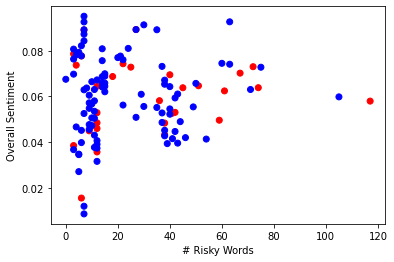

In [214]:
color_dict = {'fallen':'r', 'invest':'b'}
plt.scatter(y = text_data.positive_sentiment_mean-text_data.negetive_sentiment_mean, 
            x = text_data.risky_words, c= text_data.grade.apply(lambda x: color_dict[x]))
plt.xlabel('# Risky Words')
plt.ylabel('Overall Sentiment')

# plt.scatter(text_data.risky_words, text_data.total_words, c= text_data.grade.apply(lambda x: color_dict[x]))

In [227]:
text_data['date'] = pd.to_datetime(text_data['date'])
text_data = text_data.sort_values(by=  ['cik','date'], ascending= True).reset_index(drop = True)
text_data[text_data['cik'] == 1144519]
# text_data

,filename,text,cik,date,grade,clean_text,positive_sentiment_mean,positive_sentiment_std,negetive_sentiment_mean,negetive_sentiment_std,total_words,risky_words,fog_index,year
112,./data/processed/txt/invest/0001144519_2004-12...,10-K 1 a2153218z10-k.htm FORM 10-K QuickLinks ...,1144519,2004-12-31,invest,10k 1 a2153218z10k.htm form 10k quicklinks cli...,0.118746,0.158838,0.045956,0.108753,38742,75,11.960581,2004
113,./data/processed/txt/invest/0001144519_2005-03...,10-Q 1 a2157783z10-q.htm FORM 10-Q UNITED STAT...,1144519,2005-03-31,invest,10q 1 a2157783z10q.htm form 10q united state s...,0.142794,0.168242,0.051462,0.099700,9002,30,14.486495,2005
114,./data/processed/txt/invest/0001144519_2005-06...,10-Q 1 a2161887z10-q.htm 10-Q QuickLinks -- Cl...,1144519,2005-06-30,invest,10q 1 a2161887z10q.htm 10q quicklinks click ra...,0.121578,0.158142,0.065937,0.128164,12385,30,13.916105,2005
115,./data/processed/txt/invest/0001144519_2005-09...,10-Q 1 a2164857z10-q.htm 10-Q QuickLinks -- Cl...,1144519,2005-09-30,invest,10q 1 a2164857z10q.htm 10q quicklinks click ra...,0.127065,0.157534,0.066094,0.126130,12979,29,13.699765,2005
116,./data/processed/txt/fallen/0001144519_2005-12...,10-K 1 a06-6603_110k.htm ANNUAL REPORT PURSUAN...,1144519,2005-12-31,fallen,10k 1 a066603110k.htm annual report pursuant s...,0.116778,0.159499,0.043752,0.098366,39397,72,12.034930,2005
117,./data/processed/txt/invest/0001144519_2006-03...,10-Q 1 a2170198z10-q.htm FORM 10-Q QuickLinks ...,1144519,2006-03-31,invest,10q 1 a2170198z10q.htm form 10q quicklinks cli...,0.145937,0.169145,0.056757,0.105738,11203,35,13.970685,2006
118,./data/processed/txt/invest/0001144519_2006-06...,10-Q 1 a2172491z10-q.htm FORM 10-Q QuickLinks ...,1144519,2006-06-30,invest,10q 1 a2172491z10q.htm form 10q quicklinks cli...,0.136948,0.163651,0.063783,0.117457,14969,37,13.692816,2006
119,./data/processed/txt/fallen/0001144519_2006-09...,10-Q 1 a2174355z10-q.htm 10-Q QuickLinks -- Cl...,1144519,2006-09-30,fallen,10q 1 a2174355z10q.htm 10q quicklinks click ra...,0.143736,0.168690,0.074237,0.136981,15946,40,13.143720,2006


# Fog Score

In [165]:
import spacy
from textstat.textstat import textstatistics,legacy_round
 
# Splits the text into sentences, using
# Spacy's sentence segmentation which can
# be found at https://spacy.io/usage/spacy-101
nlp = spacy.load('en_core_web_lg')
def break_sentences(text):
    # nlp = spacy.load('en_core_web_lg')
    doc = nlp(text)
    return list(doc.sents)
 
# Returns Number of Words in the text
def word_count(text):
    sentences = break_sentences(text)
    words = 0
    for sentence in sentences:
        words += len([token for token in sentence])
    return words
 
# Returns the number of sentences in the text
def sentence_count(text):
    sentences = break_sentences(text)
    return len(sentences)
 
# Returns average sentence length
def avg_sentence_length(text):
    words = word_count(text)
    sentences = sentence_count(text)
    average_sentence_length = float(words / sentences)
    return average_sentence_length
 
# Textstat is a python package, to calculate statistics from
# text to determine readability,
# complexity and grade level of a particular corpus.
# Package can be found at https://pypi.python.org/pypi/textstat
def syllables_count(word):
    return textstatistics().syllable_count(word)
 
# Returns the average number of syllables per
# word in the text
def avg_syllables_per_word(text):
    syllable = syllables_count(text)
    words = word_count(text)
    ASPW = float(syllable) / float(words)
    return legacy_round(ASPW, 1)
 
# Return total Difficult Words in a text
def difficult_words(text):
    doc = nlp(text)
    # Find all words in the text
    words = []
    sentences = break_sentences(text)
    for sentence in sentences:
        words += [str(token) for token in sentence]
 
    # difficult words are those with syllables >= 2
    # easy_word_set is provide by Textstat as
    # a list of common words
    diff_words_set = set()
     
    for word in words:
        syllable_count = syllables_count(word)
        if word not in nlp.Defaults.stop_words and syllable_count >= 2:
            diff_words_set.add(word)
 
    return len(diff_words_set)
 
# A word is polysyllablic if it has more than 3 syllables
# this functions returns the number of all such words
# present in the text
def poly_syllable_count(text):
    count = 0
    words = []
    sentences = break_sentences(text)
    for sentence in sentences:
        words += [token for token in sentence]
     
 
    for word in words:
        syllable_count = syllables_count(word)
        if syllable_count >= 3:
            count += 1
    return count
 
 
 
def gunning_fog(text):
    per_diff_words = (difficult_words(text) / word_count(text) * 100) + 5
    grade = 0.4 * (avg_sentence_length(text) + per_diff_words)
    return grade

text_data['fog_index'] = 0

In [166]:
gunning_fog(text_data.clean_text.iloc[0])

12.034929933614144

In [167]:
# fog_index

text_data['fog_index'] = text_data.clean_text.progress_apply(lambda x: gunning_fog(x))

  0%|          | 0/124 [00:00<?, ?it/s]

In [171]:
text_data.to_csv('sentiment_data.csv')
text_data.head()

,filename,text,cik,date,grade,clean_text,positive_sentiment_mean,positive_sentiment_std,negetive_sentiment_mean,negetive_sentiment_std,total_words,risky_words,fog_index
0,./data/processed/txt/fallen/0001144519_2005-12...,10-K 1 a06-6603_110k.htm ANNUAL REPORT PURSUAN...,1144519,2005-12-31,fallen,10k 1 a066603110k.htm annual report pursuant s...,0.116778,0.159499,0.043752,0.098366,39397,72,12.034930
1,./data/processed/txt/fallen/0000027500_2001-11...,10-Q 1 d93287e10-q.txt FORM 10-Q FOR QUARTER E...,27500,2001-11-25,fallen,10q 1 d93287e10q.txt form 10q quarter ended no...,0.020338,0.090538,0.004755,0.044588,4064,6,14.708014
2,./data/processed/txt/fallen/0000095521_2005-12...,10-Q 1 d10q.htm FORM 10-Q Form 10-Q UNITED STA...,95521,2005-12-03,fallen,10q 1 d10q.htm form 10q form 10q united state ...,0.112517,0.163165,0.023437,0.069721,7228,7,15.203633
3,./data/processed/txt/fallen/0000003333_2005-05...,10-Q 1 v09820e10vq.htm FORM 10-Q e10vq Table o...,3333,2005-05-05,fallen,10q 1 v09820e10vq.htm form 10q e10vq table con...,0.119319,0.158512,0.045622,0.107093,9659,4,14.915270
4,./data/processed/txt/fallen/0001016179_2001-06...,10-Q 1 p65397e10-q.htm 10-Q e10-q UNITED STATE...,1016179,2001-06-30,fallen,10q 1 p65397e10q.htm 10q e10q united state sec...,0.103316,0.156175,0.024699,0.084460,6439,3,15.558712


# TF-IDF

In [158]:
def trial(x):
    return type(x)

In [159]:
from multiprocessing import Pool

scores = []
with Pool(os.cpu_count()) as proc_pool:
        with tqdm(total=len(text_data)) as pbar:
            for details in proc_pool.imap_unordered(trial, text_data.clean_text):
                print(details)

  0%|          | 0/124 [00:00<?, ?it/s]Process SpawnPoolWorker-2:
Process SpawnPoolWorker-3:
Process SpawnPoolWorker-1:
Traceback (most recent call last):
  File "/Users/rchaks/opt/anaconda3/envs/finance/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/rchaks/opt/anaconda3/envs/finance/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/rchaks/opt/anaconda3/envs/finance/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/Users/rchaks/opt/anaconda3/envs/finance/lib/python3.9/multiprocessing/queues.py", line 368, in get
    return _ForkingPickler.loads(res)
AttributeError: Can't get attribute 'trial' on <module '__main__' (built-in)>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/rchaks/opt/anaconda3/envs/finance/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "

KeyboardInterrupt: 

In [151]:
text_data.head()

,filename,text,cik,date,clean_text,review_clean_tokanize,postive_sentiment,negative_sentiment,total_words,risky_words,fog_index
0,0000001750_2015-05-31_10-K.txt,10-K 1 a2225345z10-k.htm 10-K Use these links ...,1750,2015-05-31 00:00:00,10k 1 a2225345z10khtm 10k use link rapidly rev...,"[10k, 1, a2225345z10khtm, 10k, use, link, rapi...",0.14,0.04,28486,36,8.182045
1,0000894315_2006-09-30_10-Q.txt,10-Q 1 l22661ae10vq.htm DEVELOPERS DIVERSIFIED...,894315,2006-09-30 00:00:00,10q 1 l22661ae10vqhtm developer diversified re...,"[10q, 1, l22661ae10vqhtm, developer, diversifi...",0.19,0.04,19455,28,146.530731
2,0000894315_2006-12-31_10-K.txt,10-K 1 l24241ae10vk.htm DEVELOPERS DIVERSIFIED...,894315,2006-12-31 00:00:00,10k 1 l24241ae10vkhtm developer diversified re...,"[10k, 1, l24241ae10vkhtm, developer, diversifi...",0.14,0.03,68034,61,90.189559
3,0000894315_2007-03-31_10-Q.txt,10-Q 1 l25860ae10vq.htm DEVELOPERS DIVERSIFIED...,894315,2007-03-31 00:00:00,10q 1 l25860ae10vqhtm developer diversified re...,"[10q, 1, l25860ae10vqhtm, developer, diversifi...",0.18,0.04,14261,23,195.820049
4,0000894315_2007-06-30_10-Q.txt,10-Q 1 l27074ae10vq.htm DEVELOPERS DIVERSIFIED...,894315,2007-06-30 00:00:00,10q 1 l27074ae10vqhtm developer diversified re...,"[10q, 1, l27074ae10vqhtm, developer, diversifi...",0.18,0.04,17321,21,166.295835


In [152]:
text_data.shape

(36, 11)

In [153]:
text_data.to_csv('../../../all_text_data.csv')